# 머신러닝 프로젝트 처음부터 끝까지

## Download

In [1]:
import tarfile
import urllib
from pathlib import Path

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = Path("datasets") / "housing"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    HOUSING_PATH.mkdir(parents=True, exist_ok=True)
    tgz_path = HOUSING_PATH / "housing.tgz"
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

## Load dataset

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = housing_path / "housing.csv"
    return pd.read_csv(csv_path)

In [6]:
housing_data = load_housing_data()

In [7]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

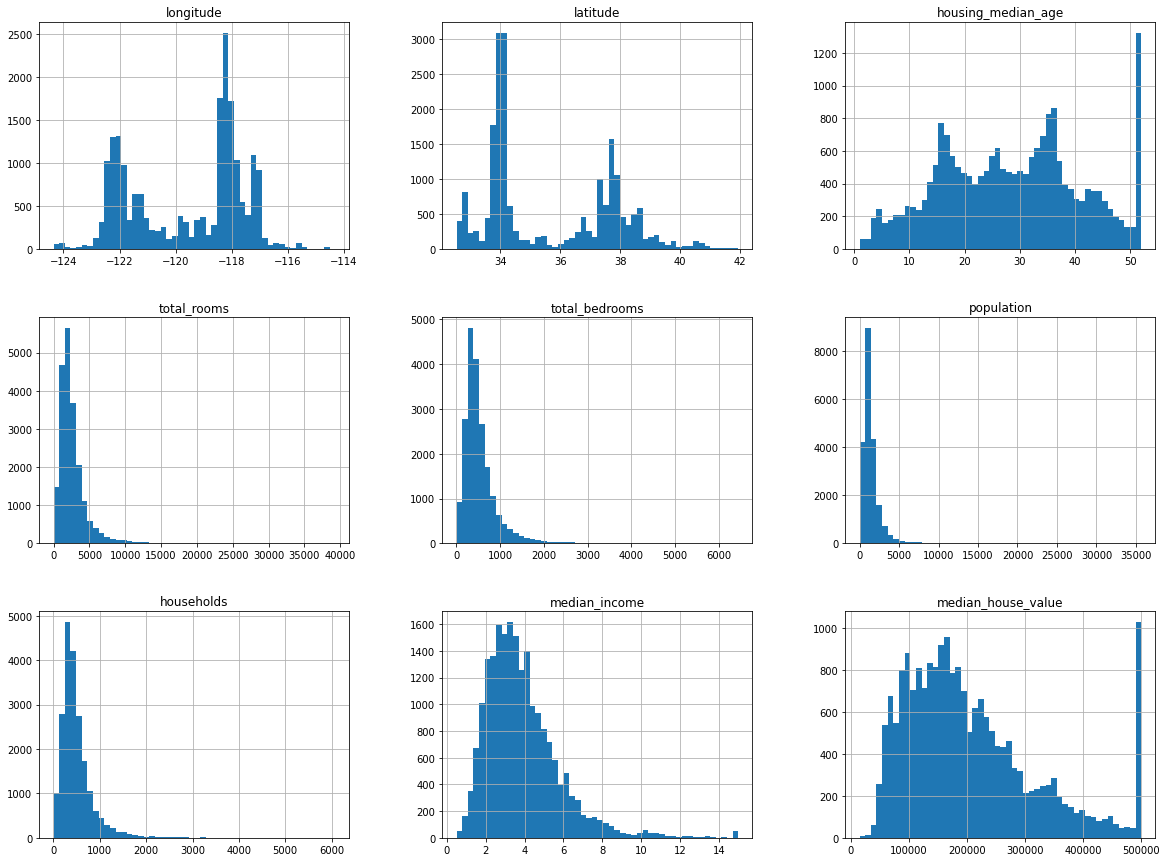

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing_data.hist(bins=50, figsize=(20, 15))

## Test Data

In [10]:
import numpy as np

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)

    train_indices = shuffled_indices[test_set_size:]
    test_indices = shuffled_indices[:test_set_size]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing_data, 0.2)

+ 재실행되어도 균일한 테스트 데이터를 유지하도록 Hashcode를 사용함

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing_data.reset_index() # add a index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

### using scikit-learn

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(housing_data, test_size=0.2, random_state=42)

+ 데이터 편향 방지

In [16]:
housing_data["income_cat"] = pd.cut(housing_data["median_income"],
                                    bins=[0., 1.5, 3., 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

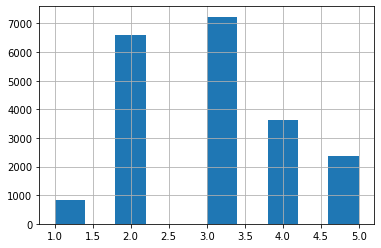

In [17]:
housing_data["income_cat"].hist()

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train = housing_data.iloc[train_index]
    strat_test = housing_data.iloc[test_index]

In [19]:
for set_ in (strat_train, strat_test): # 데이터 원복("income_cat" 컬럼 삭제)
    set_.drop("income_cat", axis=1, inplace=True)

/home/shyeon/.pyenv/versions/3.8.3/envs/hands-on/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Visualization

In [20]:
housing = strat_train.copy() # 원본 손상방지를 위한 복사본
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

### Population Density

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

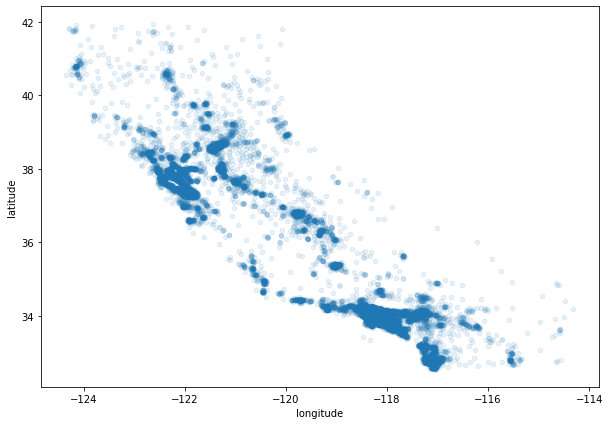

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10, 7))

### Price

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

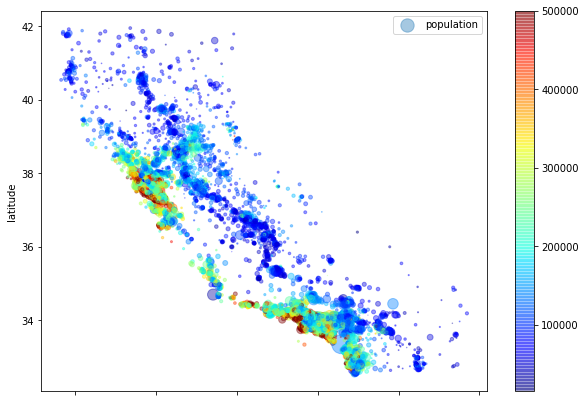

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c=housing["median_house_value"], cmap=plt.get_cmap("jet"), colorbar=True)

### Correlation

In [23]:
corr_matrix = housing.corr()

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

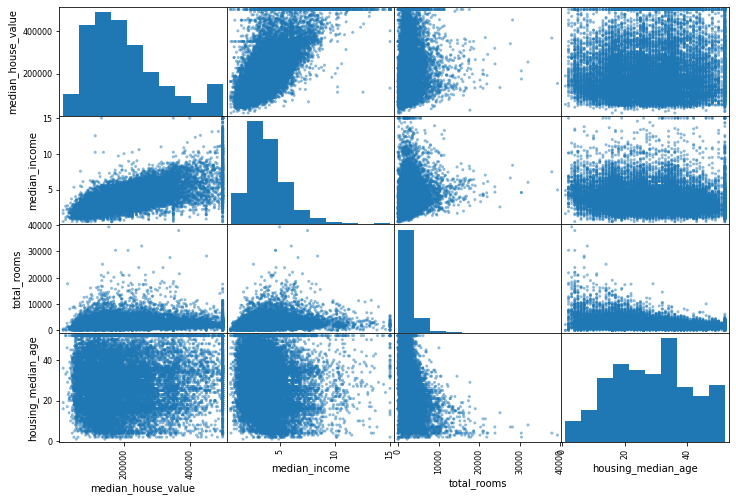

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

+ y축 500000 부근 가격 제한값으로 인해 직선모양의 패턴이 관찰됨
+ 부자연스러운 상황이므로 해당 구역의 제거를 위한 결정 필요

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

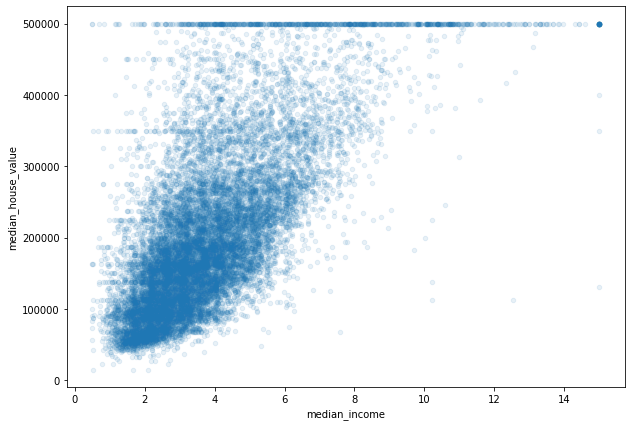

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(10, 7))

### Combination between features

In [27]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [28]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare dataset for machine learning 

In [29]:
housing = strat_train.drop("median_house_value", axis=1)
housing_labels = strat_train["median_house_value"].copy()

### Handle null field

In [30]:
for col in housing.columns:
    print(f"null rate: {sum(housing[col].isnull()) / len(housing) * 100:.2f}% / colname: {col}")

null rate: 0.00% / colname: longitude
null rate: 0.00% / colname: latitude
null rate: 0.00% / colname: housing_median_age
null rate: 0.00% / colname: total_rooms
null rate: 0.96% / colname: total_bedrooms
null rate: 0.00% / colname: population
null rate: 0.00% / colname: households
null rate: 0.00% / colname: median_income
null rate: 0.00% / colname: ocean_proximity


In [31]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

In [32]:
housing.dropna(subset=["total_bedrooms"]) # remove the rows
housing.drop("total_bedrooms", axis=1) # remove the columns
housing["total_bedrooms"].fillna(housing["total_bedrooms"].median(), inplace=True) # fill null fields

### using scikit-learn

#### Numerical Features

In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [34]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_ == housing_num.median().values

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [35]:
X = imputer.transform(housing_num) # test과정에서 다른 컬럼에서 null값이 나올 수 있으므로 모두 포함

In [36]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [37]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


#### Catergorical Features
+ OrdinalEncoder

In [38]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [39]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [40]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

+ OneHotEncoder

In [41]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # sparse matrix

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [42]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

+ Customized Encodcer

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [44]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedromms_per_room=True):
        self.add_bedromms_per_room = add_bedromms_per_room
    def fit(self, X):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedromms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedromms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [45]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [46]:
pd.DataFrame(housing_extra_attribs, columns=housing.columns.to_list() + ["rooms_per_household", "population_per_household"]) # 9, 10 컬럼이 추가됨

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785
...,...,...,...,...,...,...,...,...,...,...,...
16507,-118.13,34.2,46,1271,236,573,210,4.9312,INLAND,6.05238,2.72857
16508,-117.56,33.88,40,1196,294,1052,258,2.0682,INLAND,4.63566,4.07752
16509,-116.4,34.09,9,4855,872,2098,765,3.2723,INLAND,6.34641,2.74248
16510,-118.01,33.82,31,1960,380,1356,356,4.0625,<1H OCEAN,5.50562,3.80899


### Scaling

+ StandardScaler: 평균이 0과 표준편차가 1이 되도록 변환.
+ RobustScaler: 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환.
+ MinMaxScaler: 최대값이 각각 1, 최소값이 0이 되도록 변환
+ MaxAbsScaler: 0을 기준으로 절대값이 가장 큰 수가 1또는 -1이 되도록 변환

### Pipeline

#### Numeric features

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [48]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [49]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

#### ColumnTransformer
+ 각 열마다 적절한 변환기 사용 가능
+ 해당 컬럼의 삭제를 원한다면 drop, 변환을 적용하지 않는다면 passthrough로 지정
+ 나열되지 않은 열은 기본적으로 삭제됨

In [50]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) # list of columns
cat_attribs = ["ocean_proximity"]

In [51]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),   # 숫자형과  
    ('cat', OneHotEncoder(), cat_attribs) # 문자형을 별도로 처리
])

housing_prepared = full_pipeline.fit_transform(housing) # 밀집도가 입계값(0.3)보다 낮은 경우에는 희소행렬을 반환

## Select and train the model

### Evalute a trained model in training step

#### Linear regression

In [52]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [53]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

In [54]:
some_data_prepared = full_pipeline.transform(some_data)
print("Prediction:", lin_reg.predict(some_data_prepared))

Prediction: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [55]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


+ RMSE

In [56]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse # 과소적합이 의심됨

68628.19819848922

In [57]:
lin_reg.score(X=housing_prepared, y=housing_labels)

0.6481624842804428

#### Decision Tree Regressor

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [59]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse # 과대적합이 의심됨

0.0

### Cross validation

+ Tree and Linear regression

In [60]:
def display_score(scores):
    """Display evaluation of a prediction model
    """
    print("score:", scores)
    print("mean:", scores.mean())
    print("std:", scores.std())

In [61]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [62]:
display_score(tree_rmse_scores)

score: [69279.28066933 66871.49568504 70895.08862703 69603.88136061
 71245.99723174 75300.64571265 70130.24356025 71251.99236451
 76525.36337329 68468.41246203]
mean: 70957.2401046464
std: 2797.53307268817


In [63]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [64]:
display_score(lin_rmse_scores)

score: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean: 69052.46136345083
std: 2731.674001798348


+ Random Forest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
forest_rmse_scores = np.sqrt(-scores)

In [66]:
display_score(forest_rmse_scores)

score: [49511.81368326 47672.67262739 49741.72472467 52489.37697155
 49734.70008088 53266.68943198 48756.18075857 48467.66697841
 53350.98246031 50131.85227013]
mean: 50312.36599871532
std: 1919.0101716479157


+ Save model

```
import joblib

joblib.dump(my_model, "my_model.pkl")
my_model_loaded = joblib.load("my_model.pkl")
```

## Tune model

### Grid search

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, n_jobs=-1,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

+ 결과 확인

In [68]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [69]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [70]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63681.15400451133 {'max_features': 2, 'n_estimators': 3}
56217.768837731004 {'max_features': 2, 'n_estimators': 10}
53235.7243344127 {'max_features': 2, 'n_estimators': 30}
60332.933093408166 {'max_features': 4, 'n_estimators': 3}
53486.357499432524 {'max_features': 4, 'n_estimators': 10}
50707.329944566125 {'max_features': 4, 'n_estimators': 30}
58321.22479795509 {'max_features': 6, 'n_estimators': 3}
52274.073697661865 {'max_features': 6, 'n_estimators': 10}
49990.18028215135 {'max_features': 6, 'n_estimators': 30}
58513.88771008254 {'max_features': 8, 'n_estimators': 3}
52062.82655721793 {'max_features': 8, 'n_estimators': 10}
50015.92971085712 {'max_features': 8, 'n_estimators': 30}
61833.80720466459 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54212.235960222344 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61161.29205452301 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52136.97053062049 {'bootstrap': False, 'max_features': 3, 'n_estimators

+ Feature 중요도

In [71]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.27745633030532263, 'median_income'),
 (0.1702917693172004, 'INLAND'),
 (0.10624184015315456, 'pop_per_hhold'),
 (0.10237132961372214, 'bedrooms_per_room'),
 (0.07920866031443757, 'longitude'),
 (0.06757888963365553, 'latitude'),
 (0.06477877177570324, 'rooms_per_hhold'),
 (0.04271601318830501, 'housing_median_age'),
 (0.018459220425358424, 'total_rooms'),
 (0.017913368487671593, 'population'),
 (0.017525612898999995, 'total_bedrooms'),
 (0.01564427672192633, 'households'),
 (0.01189255977073716, '<1H OCEAN'),
 (0.004404569496991526, 'NEAR OCEAN'),
 (0.003473520049150005, 'NEAR BAY'),
 (4.32678476640283e-05, 'ISLAND')]

### Evaluate the system using test dataset

+ 테스트를 훈련해서는 안되므로 tranform 만 사용해야 함

In [72]:
final_model = grid_search.best_estimator_

X_test = strat_test.drop("median_house_value", axis=1)
y_test = strat_test["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions) 
fianl_rmse = np.sqrt(final_mse)

In [73]:
fianl_rmse

47760.27457276171

+ 신뢰구간

In [75]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45807.89400253, 49635.91946951])